In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu ## for those wonderful p-values!

## Nature journal settings
plt.rcParams["font.family"] = "Arial"
colors = ["#E64B35FF", "#3C5488FF", "#00A087FF", "#4DBBD5FF", "#F39B7FFF", "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF"]
sns.set_palette(sns.color_palette(colors))

plt.rcParams.update({"font.size":18}) ## Set fontsize

In [3]:
df_fn = 'run_2d/analysis/m.csv'
df = pd.read_csv(df_fn)
df['frac-used'] = df['percent-used'] / 100.0
df.head()

,source,target,pair,percent-heldout,percent-used,seed,transfer,target_only_mean,percent-to-match-TL,efficiency-gain,frac-used
0,REP,GDSC,REP_GDSC,20,80,0,0.810710,0.813357,78.252260,0.978153,0.8
1,REP,GDSC,REP_GDSC,20,80,1,0.818809,0.813357,84.535671,1.056696,0.8
2,REP,GDSC,REP_GDSC,20,80,2,0.812328,0.813357,79.321074,0.991513,0.8
3,REP,GDSC,REP_GDSC,20,80,3,0.827824,0.813357,90.000000,1.125000,0.8
4,REP,GDSC,REP_GDSC,20,80,4,0.829023,0.813357,90.000000,1.125000,0.8


In [30]:
from scipy.stats import spearmanr
np.random.seed(100)

## Generate some fake data.
dataset_names = ['CTD2_GDSC', 'CTD2_REP', 'GDSC_CTD2']
variable_values = [5, 10, 15, 20]

## Get those p-values!
for dataset in dataset_names:
    sub_df = df[(df["pair"]==dataset) & df["percent-used"].isin(variable_values)]
    print(dataset, spearmanr(sub_df["percent-used"], sub_df["efficiency-gain"]))


CTD2_GDSC SignificanceResult(statistic=-0.9259324188501412, pvalue=1.18015191238613e-17)
CTD2_REP SignificanceResult(statistic=-0.9530517783980534, pvalue=2.590063838698196e-21)
GDSC_CTD2 SignificanceResult(statistic=-0.6373049493759341, pvalue=9.770295245426506e-06)


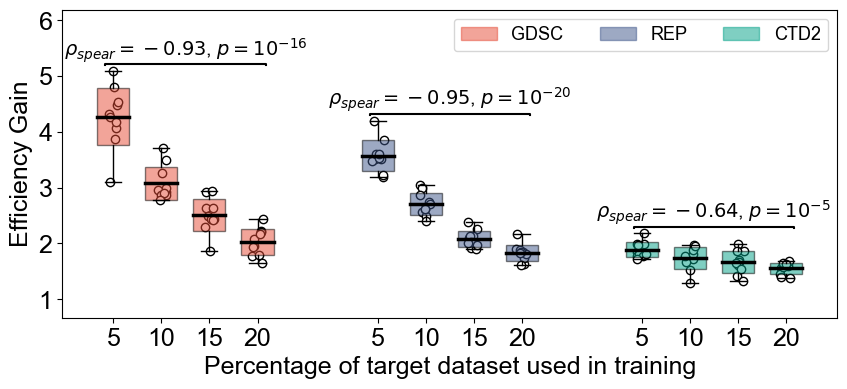

In [33]:
curr_pos = 0

fig, ax = plt.subplots(figsize=(10,4))
stats = []
positions = []
for dataset in dataset_names:
    for var in variable_values:
        v = df[(df["pair"]==dataset)&(df["percent-used"]==var)]["efficiency-gain"]
        mu = np.mean(v)
        stdv = np.std(v)
        stats.append({"med":mu, 
                      "q1":mu-stdv, 
                      "q3":mu+stdv, 
                      "whislo":np.min(v), 
                      "whishi":np.max(v), 
                      "label":str(var)})
        
        ax.scatter(x=(curr_pos + np.random.uniform(-0.75, 0.75, size=len(v))), 
                   y=v, 
                   color='white', 
                   edgecolors="black", 
                   zorder=-1)
        positions.append(curr_pos)
        curr_pos += 6
    curr_pos += 9

## Make boxplots
bplot = ax.bxp(stats, 
               positions=positions, 
               widths=4, 
               showfliers=False, 
               medianprops=dict(linestyle='-', linewidth=2.5, color='black'), 
               patch_artist=True, 
               zorder=0)
for i, patch in enumerate(bplot['boxes']):
    patch.set_facecolor(colors[i//4]) ## Use those nature colors
    patch.set_alpha(0.5)

plt.xlabel("Percentage of target dataset used in training")
plt.ylabel("Efficiency Gain")
plt.ylim(np.min(df['efficiency-gain'])-0.1, np.max(df['efficiency-gain'])+0.55)

## P-values + spearman rho
p_values = [r"$\rho_{spear} = -0.93$, $p=10^{-16}$", r"$\rho_{spear} = -0.95$, $p=10^{-20}$", r"$\rho_{spear} = -0.64$, $p=10^{-5}$"] 
for i, dataset in enumerate(dataset_names):
    h = 0.02
    sub_df = df[(df["pair"]==dataset)]
    y = np.max(sub_df["efficiency-gain"])+0.1
    x1, x2 = positions[4*i]-1, positions[4*i + 3]+1
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color='k')
    plt.text((x1+x2)*.5, y+h, p_values[i], ha='center', va='bottom',color='k', fontsize=14)

patch1 = mpatches.Patch(color=colors[0], alpha=0.5, label='GDSC')
patch2 = mpatches.Patch(color=colors[1], alpha=0.5, label='REP')
patch3 = mpatches.Patch(color=colors[2], alpha=0.5, label='CTD2')

plt.legend(handles=[patch1, patch2, patch3], ncol=3, fontsize=13, loc='upper right')
plt.savefig("plots/efficiency-gain.png", bbox_inches='tight')